In [517]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import random
import time
import scipy.optimize as opt


plt.rcParams["figure.figsize"] = (20, 10)

Function: $y = \frac{exp(-1*x)}{2+3*x}$

In [518]:
func = lambda x, b1, b2, b3: np.e ** (-b1 * x) / (b2 + b3 * x)
minimizing_func = lambda b: np.sum((func(xs, b[0], b[1], b[2]) - ys) ** 2)

const_lr = lambda n, start: start
exp_lr = lambda n, start: start * np.exp(-0.01 * n)

In [519]:
start_point = [2, 4, 5]

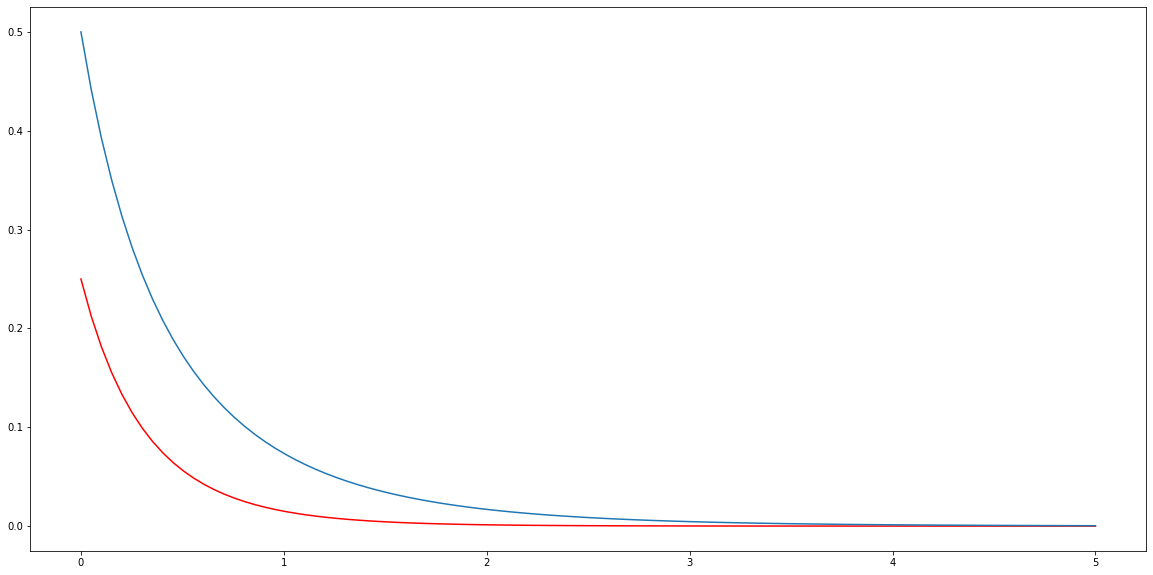

In [520]:
exp_beta_1 = 1
exp_beta_2 = 2
exp_beta_3 = 3

xs = np.linspace(0, 5, 100)
ys = func(xs, exp_beta_1, exp_beta_2, exp_beta_3)

plt.plot(xs, func(xs, *start_point), '-r')
plt.plot(xs, ys)

# GD

In [521]:
def partial(f, i, x):
    h = 1e-5
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)

def grad(f, x):
    return np.array([partial(f, i, x) for i in range(len(x))])

def minibatch_grad(func, x, batch=30):
    return grad(func, x)

def cancel_condition(x):
    return np.linalg.norm(grad(minimizing_func, x)) < 1e-6

def minibatch_sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start

    points = list()
    grads = list()
    loss = list()
    points.append(x)
    for i in range(1, epoch):
        grads.append(np.linalg.norm(minibatch_grad(f, x, batch)))
        loss.append(f(x))
        x = x - lr_strategy(i, lr) * np.array(minibatch_grad(f, x, batch))
        points.append(x)
        if cancel_condition(x):
            break

    return [np.array(points), np.array(grads), np.array(loss)]


def gd(f, lr, start, lr_strategy=const_lr, epoch=20):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=30)

Итераций 18613


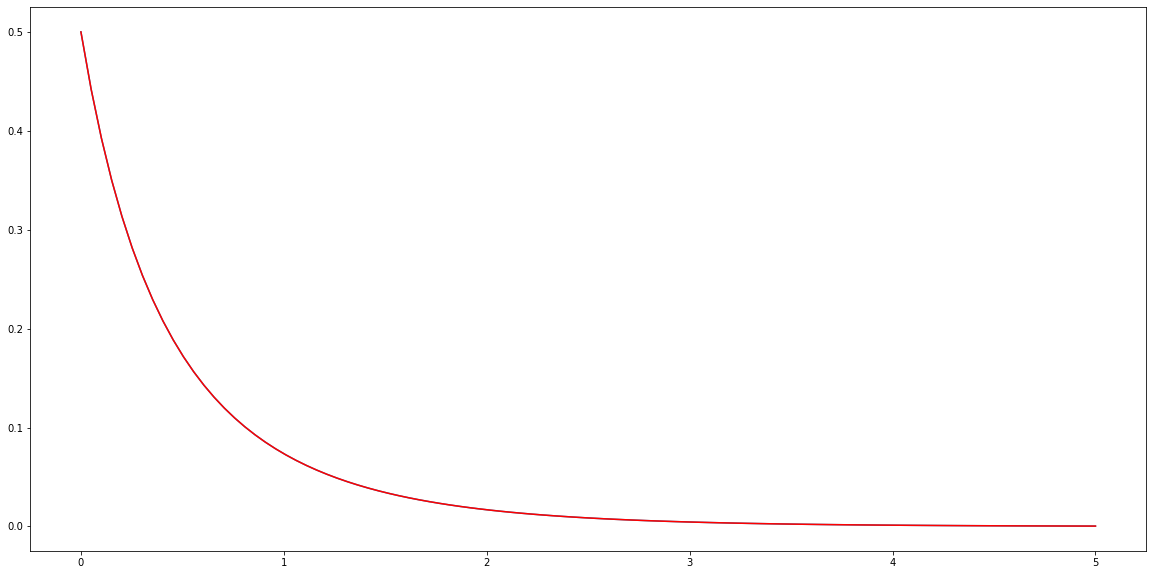

In [522]:
gd_points, gd_grads, gd_loss = gd(minimizing_func, 0.3, start=start_point, lr_strategy=const_lr, epoch=50000)

print("Итераций", len(gd_points))

ans = gd_points[-1]
plt.plot(xs, func(xs, ans[0], ans[1], ans[2]), '-')

plt.plot(xs, ys, 'r')


# Adam

In [523]:
def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    prev_grad = np.array([0, 0, 0])
    prev_v = np.array([0, 0, 0])

    points = list()
    grads = list()
    loss = list()

    points.append(start)

    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        grads.append(np.linalg.norm(gr))
        loss.append(f(x))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) * g / np.sqrt(v)
        prev_v = v
        prev_grad = g
        points.append(x)
        if cancel_condition(x):
            break

    return [np.array(points), np.array(grads), np.array(loss)]

Итераций:  627


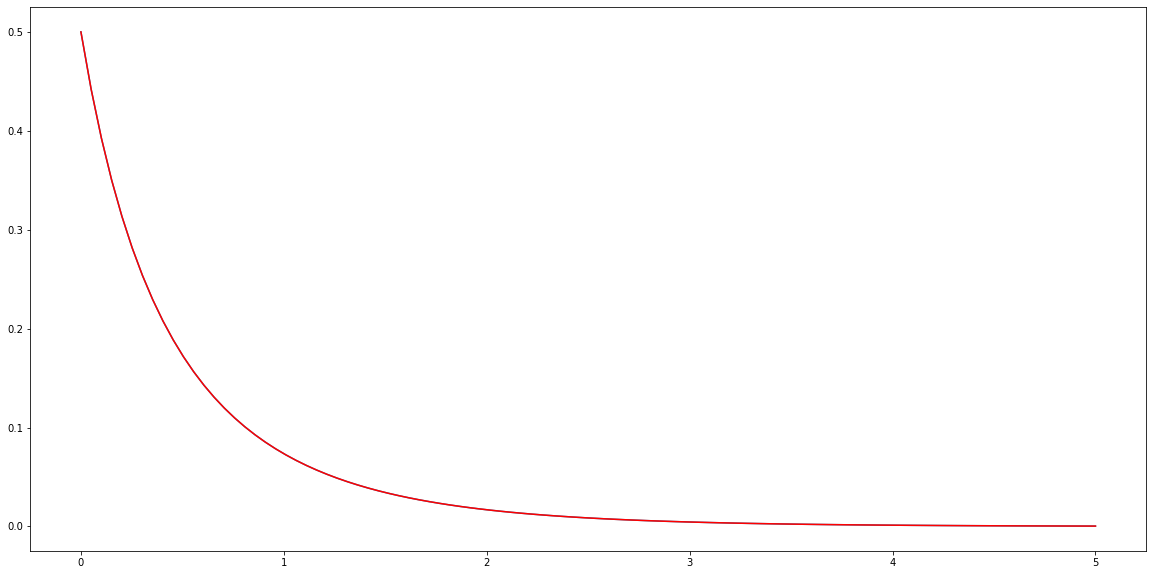

In [524]:
adam_points, adam_grads, adam_loss = adam(minimizing_func, b1=0.5, b2=0.5, lr=0.2, start=start_point, lr_strategy=exp_lr,
                             epoch=50000,
                             batch=30)

ans = adam_points[-1]

plt.plot(xs, func(xs, ans[0], ans[1], ans[2]))

plt.plot(xs, ys, 'r')

print("Итераций: ", len(adam_points))


------------------------------------------------------------------

# Newton

In [525]:
def minimizing_func2(b, idxs=range(100)):
    res = 0
    for i in idxs:
        res += (func(xs[i], b[0], b[1], b[2]) - ys[i]) ** 2
    return res

In [526]:
def partial2(f, i, x, idxs):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad2(f, x, idx_of_term, idx_of_var):
    return partial2(f, idx_of_var, x, idx_of_term)

In [527]:
# p = -(J^T * J)^(-1) J * r

def calcP(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    JT = np.array(res)
    hh = -np.linalg.inv(JT @ JT.T) @ JT
    rs = list()
    for i in range(100):
        rs.append(minimizing_func2(x, [i]))
    res = hh @ np.array(rs).T
    return res


def newton(f, lr, start, lr_strategy=const_lr, epoch=20):
    x = start
    points = list()
    grads = list()
    loss = list()
    points.append(start)
    for i in range(1, epoch):
        loss.append(f(x))
        grads.append(np.linalg.norm(grad(minimizing_func, x)))
        x = x + lr_strategy(i, lr) * np.array(calcP(x))
        points.append(x)
        if cancel_condition(x):
            break

    return [np.array(points), grads, loss]

Итераций 23


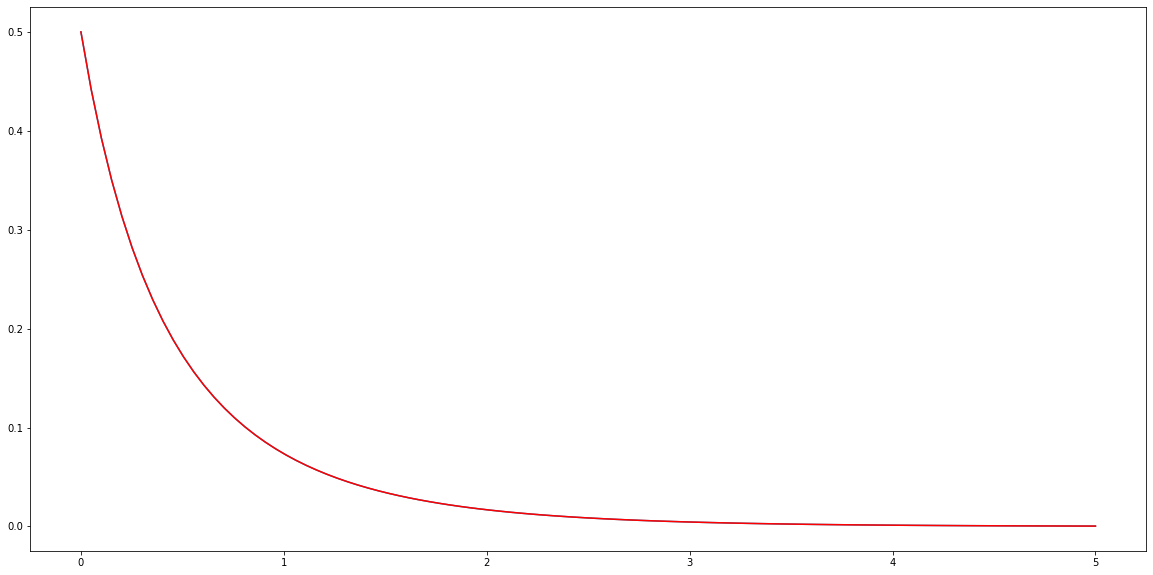

In [528]:
newton_points, newton_grads, newton_loss = newton(minimizing_func2, 1, start=start_point, lr_strategy=exp_lr, epoch=2000)

print("Итераций", len(newton_points))

ans = newton_points[-1]
plt.plot(xs, func(xs, ans[0], ans[1], ans[2]), '-')

plt.plot(xs, ys, 'r')

## DOGLEG

In [529]:
def getRo(f, x, p):
    fx = f(x) - f(x + p)
    mk = m(f, x, np.array([0, 0, 0])) - m(f, x, p)
    return fx / mk


def m(f, x, p):
    return f(x) + np.transpose(grad(f, x)) @ p + 1 / 2 * np.transpose(p) @ calcH(x) @ p

def calcH(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    JT = np.array(res)
    return 2 * JT @ JT.T


def calcStep(f, x, delta):
    H = calcH(x)
    gr = grad(f, x)

    pH = -np.linalg.inv(H) @ gr

    if np.linalg.norm(pH) <= delta:
        return pH

    pU = - (np.dot(gr, gr) / np.dot(gr, np.dot(H, gr))) * gr

    if np.linalg.norm(pU) >= delta:
        return delta * pU / np.linalg.norm(pU)

    A = pU
    B = pH - pU

    D4 = (A.T @ B) * (A.T @ B) - (B.T @ B) * (A.T @ A - delta * delta)

    T =  (-A.T @ B + np.sqrt(D4)) / (B.T @ B)

    return pU + T * B


def dogleg(f, start, delta=1, nu=1 / 4, epoch=20, delta_max=100):
    x = start

    points = list()
    grads = list()
    loss = list()

    points.append(start)

    for i in range(1, epoch):
        grads.append(np.linalg.norm(grad(f, x)))
        loss.append(f(x))

        p = calcStep(f, x, delta)

        ro = getRo(f, x, p)

        if ro < 1 / 4:
            delta = 1 / 4 * delta
        elif ro > 3 / 4 and np.linalg.norm(ro) == delta:
            delta = min(2 * delta, delta_max)
        else:
            delta = delta

        if ro > nu:
            x = x + p
        else:
            x = x

        points.append(x)

        if cancel_condition(x):
            break

    return [np.array(points), np.array(grads), np.array(loss)]

In [530]:
dogleg_points, dogleg_grads, dogleg_loss = dogleg(minimizing_func, start_point, delta=1, epoch=1000)

# BFGS

In [531]:
def grad_with_fixed_func(x):
    return np.array(minibatch_grad(minimizing_func, x))

def bfgs(f, start, epoch):
    x = start

    points = list()
    grads = list()
    loss = list()

    points.append(x)

    I = np.eye(len(x))
    H = I

    gr = grad(f, x)
    loss.append(f(x))

    grads.append(np.linalg.norm(gr))
    for i in range(1, epoch):

        p = - H @ gr

        coef = opt.line_search(f, grad_with_fixed_func, x, p)[0]

        new_x = x + coef * p

        s = new_x - x
        x = new_x
        new_grad = grad(f, x)
        grads.append(np.linalg.norm(new_grad))
        loss.append(f(x))
        points.append(x)
        y = new_grad - gr

        if cancel_condition(x):
            break

        gr = new_grad

        y = np.array([y])
        s = np.array([s])
        y = np.reshape(y,(len(x),1))
        s = np.reshape(s,(len(x),1))

        ro = 1.0 / (y.T @ s)
        H = (I - ro * s @ y.T) @ H @ (I - ro * y @ s.T) + ro * s @ s.T

    return [points, grads, loss]

In [532]:
bfgs_points, bfgs_grads, bfgs_loss = bfgs(minimizing_func, start_point, epoch=1000)

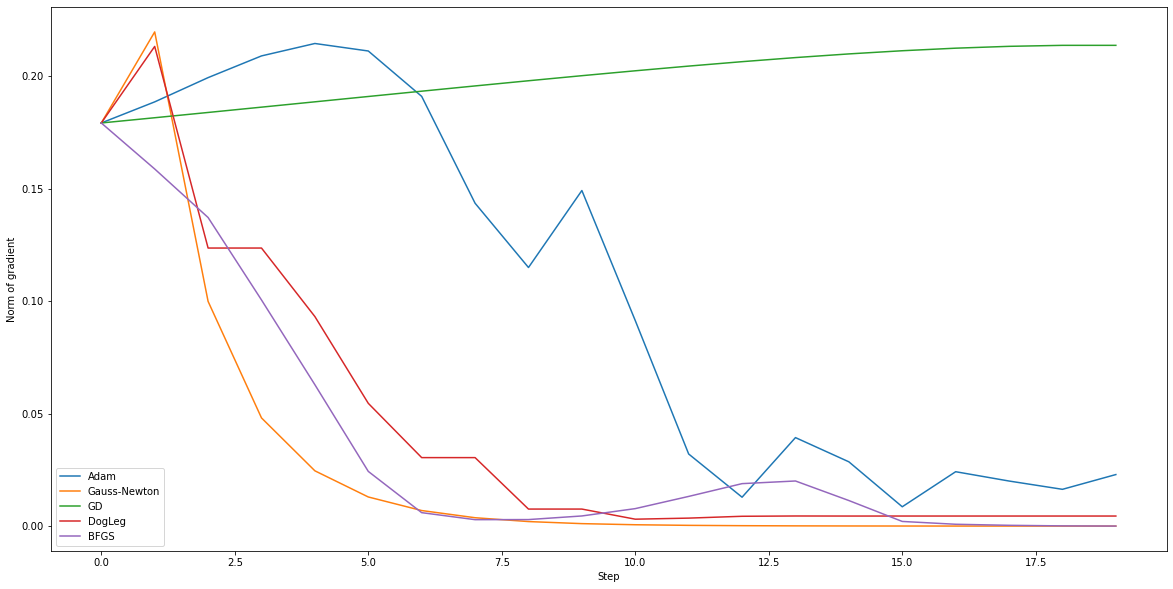

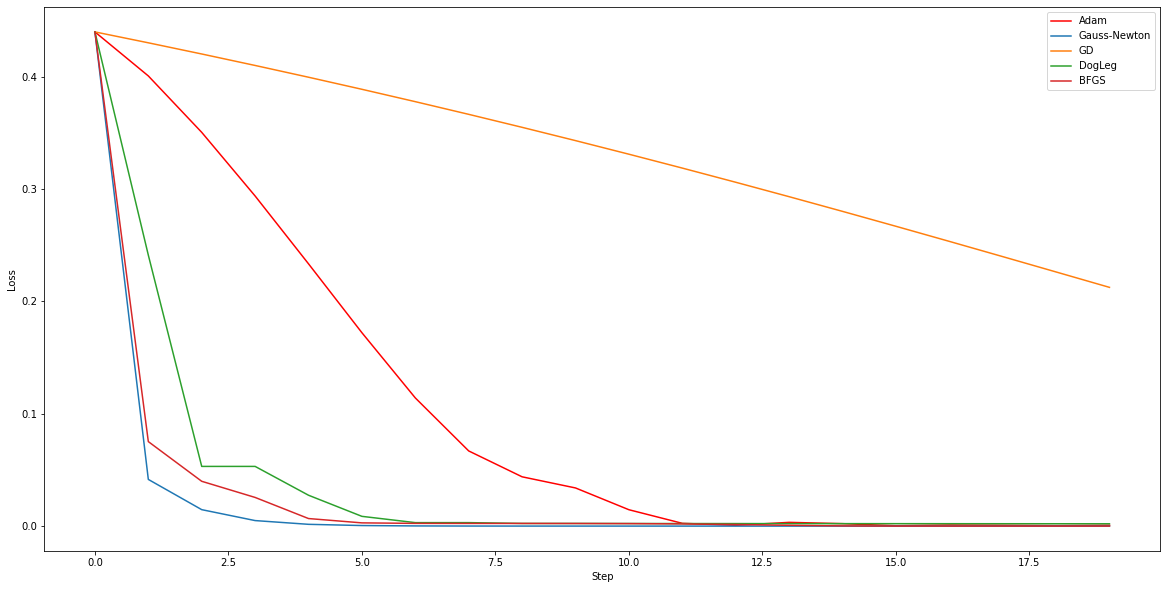

In [533]:
size = min(len(gd_points), len(adam_points), len(newton_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, adam_grads[:size],  label='Adam')
plt.plot(ss, newton_grads[:size], label='Gauss-Newton')
plt.plot(ss, gd_grads[:size], label='GD')
plt.plot(ss, dogleg_grads[:size], label='DogLeg')
plt.plot(ss, bfgs_grads[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

plt.show()

plt.plot(ss, adam_loss[:size], 'r', label='Adam')
plt.plot(ss, newton_loss[:size], label='Gauss-Newton')
plt.plot(ss, gd_loss[:size], label='GD')
plt.plot(ss, dogleg_loss[:size], label='DogLeg')
plt.plot(ss, bfgs_loss[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()

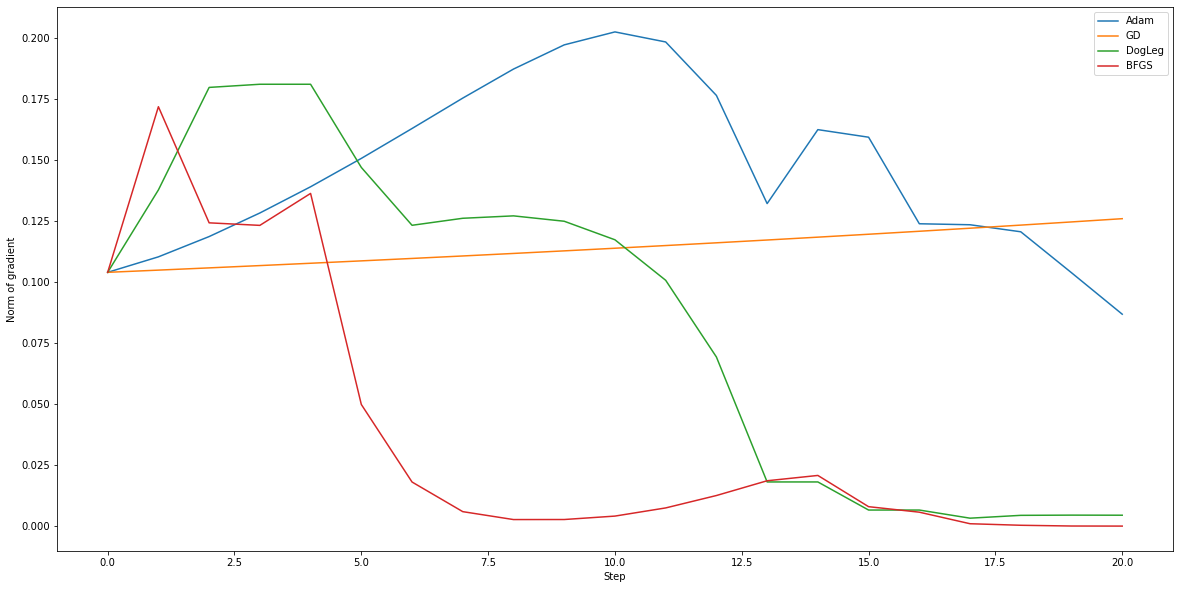

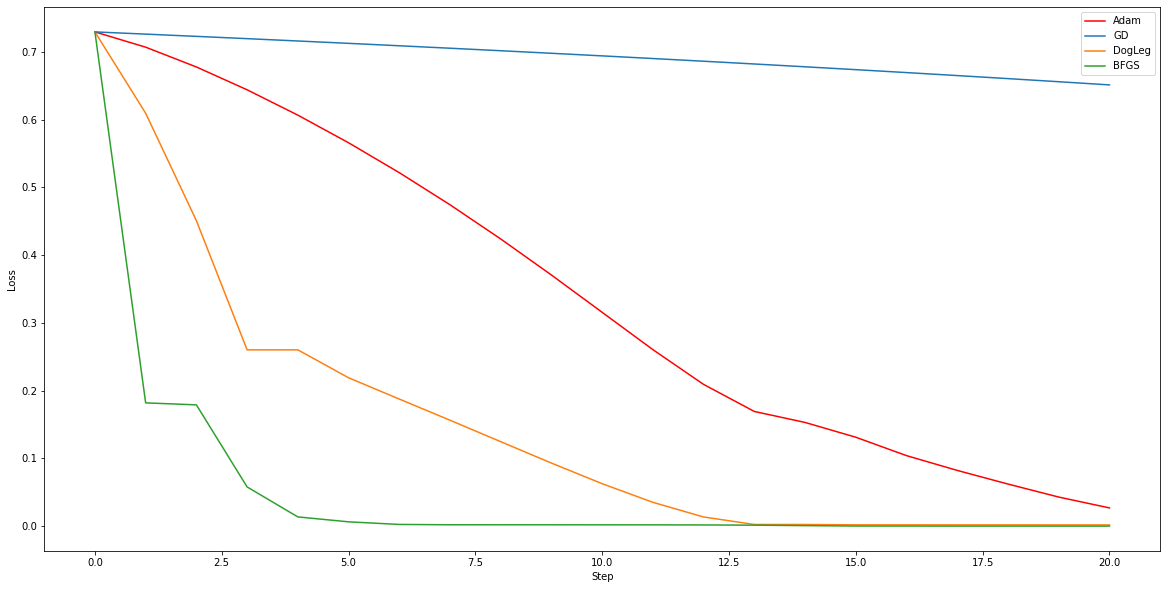

In [534]:
start_point=[3,6,5]

gd_points, gd_grads, gd_loss = gd(minimizing_func, 0.3, start=start_point, lr_strategy=const_lr, epoch=50000)
adam_points, adam_grads, adam_loss = adam(minimizing_func, b1=0.5, b2=0.5, lr=0.2, start=start_point, lr_strategy=exp_lr,epoch=50000, batch=30)
bfgs_points, bfgs_grads, bfgs_loss = bfgs(minimizing_func, start_point,  epoch=1000)
dogleg_points, dogleg_grads, dogleg_loss = dogleg(minimizing_func, start_point, delta=1, epoch=1000)

size = min(len(gd_points), len(adam_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, adam_grads[:size],  label='Adam')
plt.plot(ss, gd_grads[:size], label='GD')
plt.plot(ss, dogleg_grads[:size], label='DogLeg')
plt.plot(ss, bfgs_grads[:size], label='BFGS')



plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

plt.show()

size = min(len(gd_points), len(adam_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, adam_loss[:size], 'r', label='Adam')
plt.plot(ss, gd_loss[:size], label='GD')
plt.plot(ss, dogleg_loss[:size], label='DogLeg')
plt.plot(ss, bfgs_loss[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()